## **üóΩUnited States of America Cities Monthly Temperature Forecasting.**

This notebook is part of our proposed solution for the NASA Mission Pale Blue Dot Visualization Challenge. Our goal is to construct a suite of models that predict the average monthly temperatures in U.S. cities to achieve the highest possible performance.

The study utilizes the Land Surface Temperature By City dataset, published by Berkeley Earth on Kaggle, which provides a robust foundation for our analysis and model development by providing comprehensive temperature records for cities around the world.

By using this data, we aim to produce accurate, reliable forecasts that can contribute to our understanding of climate trends and inform future climate-related decisions and policies. Please note that the dataset used in this study can be accessed via the link provided below.


Dataset: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


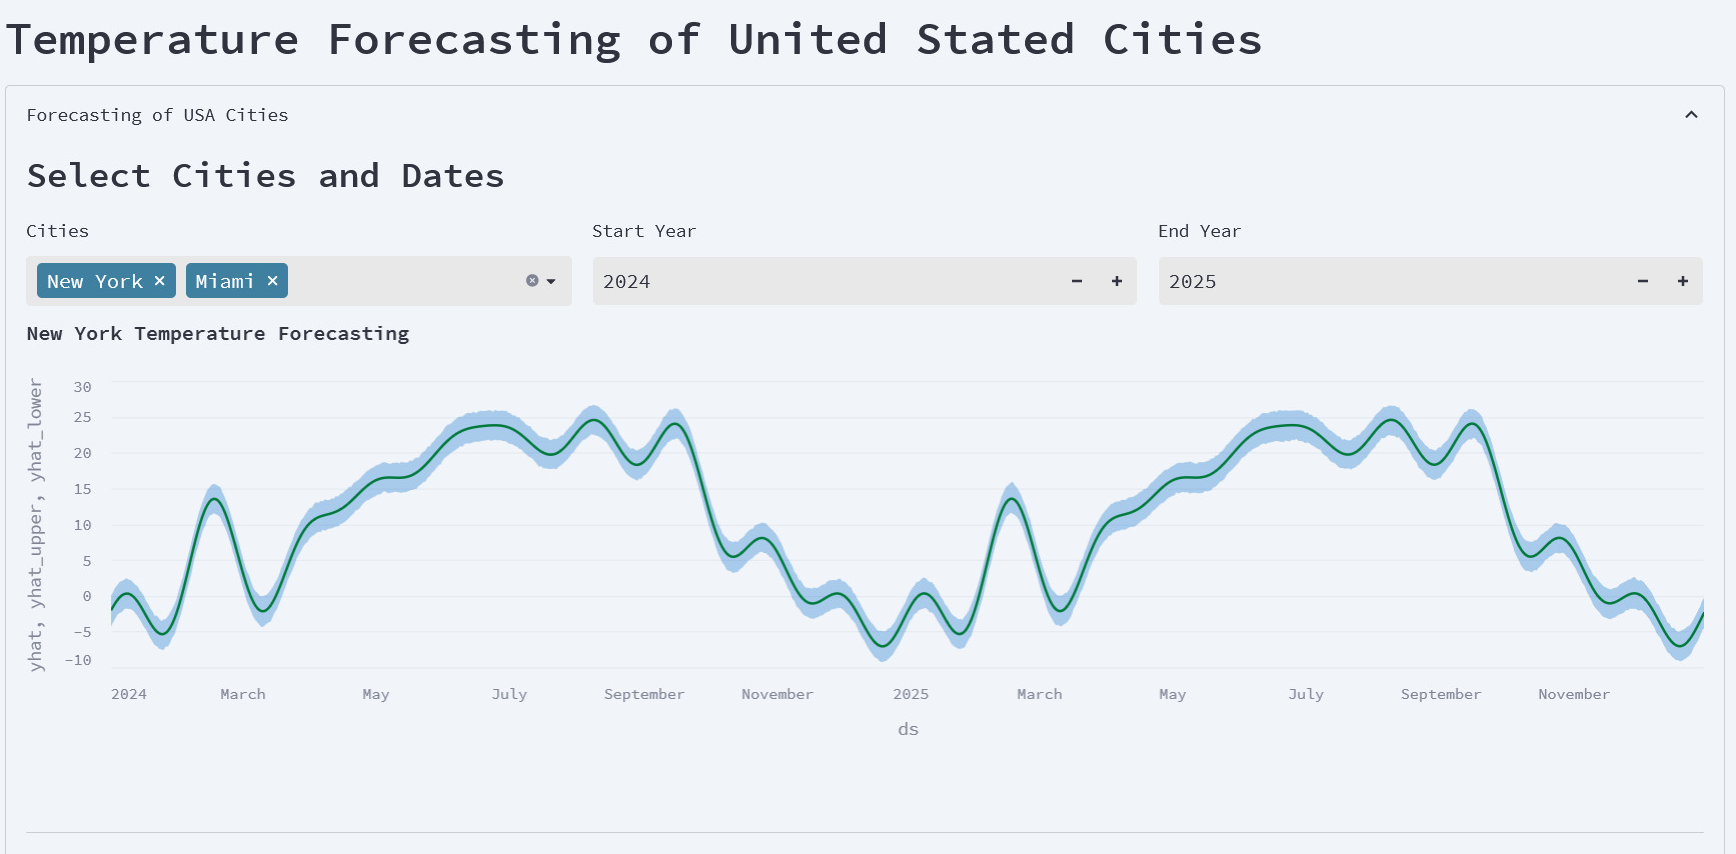

In [3]:
from PIL import Image
img = Image.open('../Images/NY Forecasting.png')
img

---

### **Imports**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
sns.set_theme()

### **Data Loading & First Preprocessing**

In [41]:
df = pd.read_csv('../Dataset/Temperature/GlobalLandTemperaturesByCity.csv')
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  √Örhus   
1  1743-12-01                 NaN                            NaN  √Örhus   
2  1744-01-01                 NaN                            NaN  √Örhus   
3  1744-02-01                 NaN                            NaN  √Örhus   
4  1744-03-01                 NaN                            NaN  √Örhus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E

### **Data Pre-Processing**

In [42]:
df.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

Since data previus to 1970 were not fully collected for every cities, we will only work with data from 1970 forward.

In [43]:
# Date to Datetime
df['dt'] = pd.to_datetime(df['dt'])
df = df[df['dt'].dt.year >= 1970]
df.head(5)

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
2714 1970-01-01              -3.488                          0.327  √Örhus   
2715 1970-02-01              -4.962                          0.582  √Örhus   
2716 1970-03-01               0.361                          0.367  √Örhus   
2717 1970-04-01               3.350                          0.296  √Örhus   
2718 1970-05-01              11.343                          0.311  √Örhus   

      Country Latitude Longitude  
2714  Denmark   57.05N    10.33E  
2715  Denmark   57.05N    10.33E  
2716  Denmark   57.05N    10.33E  
2717  Denmark   57.05N    10.33E  
2718  Denmark   57.05N    10.33E

In the filtered data set (1970-forward), there are several instances of NaN values. To address this issue, the fill_nan_values function enables the imputation of missing values using the mean as the criterion.

In [44]:
df.isna().sum()

dt                                  0
AverageTemperature               3070
AverageTemperatureUncertainty    3070
City                                0
Country                             0
Latitude                            0
Longitude                           0
dtype: int64

In [45]:
def fill_nan_values(df):
    # To Datetime
    df['dt'] = pd.to_datetime(df['dt'])
    
    # Month Attribute
    df['Month'] = df['dt'].dt.month
    
    # Calculate Mean grouped by City Country Month
    avg_temp = df.groupby(['City', 'Country', 'Month'])['AverageTemperature'].transform('mean')
    avg_temp_unc = df.groupby(['City', 'Country', 'Month'])['AverageTemperatureUncertainty'].transform('mean')
    
    # Impute NaN Values
    df['AverageTemperature'].fillna(avg_temp, inplace=True)
    df['AverageTemperatureUncertainty'].fillna(avg_temp_unc, inplace=True)
    
    return df


In [46]:
df = fill_nan_values(df)
df.isna().any()

dt                               False
AverageTemperature               False
AverageTemperatureUncertainty    False
City                             False
Country                          False
Latitude                         False
Longitude                        False
Month                            False
dtype: bool

After imputation there is no missing values in the data.

In [47]:
# String Coordinate to Real Coordinates
def convert_coordinates(coord):
    direction = {'N':1, 'S':-1, 'E':1, 'W':-1}
    if isinstance(coord, str): # Comprueba si la coordenada es una cadena
        if coord[-1] in direction: 
            return direction[coord[-1]]*float(coord[:-1])
    return coord

In [48]:
# Apply Coordinate Converter
df['Latitude'] = df['Latitude'].apply(convert_coordinates)
df['Longitude'] = df['Longitude'].apply(convert_coordinates)
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
2714 1970-01-01              -3.488                          0.327  √Örhus   
2715 1970-02-01              -4.962                          0.582  √Örhus   
2716 1970-03-01               0.361                          0.367  √Örhus   
2717 1970-04-01               3.350                          0.296  √Örhus   
2718 1970-05-01              11.343                          0.311  √Örhus   

      Country  Latitude  Longitude  Month  
2714  Denmark     57.05      10.33      1  
2715  Denmark     57.05      10.33      2  
2716  Denmark     57.05      10.33      3  
2717  Denmark     57.05      10.33      4  
2718  Denmark     57.05      10.33      5

#### **Saving Preprocessed Data**

In [49]:
df.to_csv('WorldData.csv')

#### **Data Selection (USA Cities)**

In [50]:
countries = df['Country'].unique()
print(countries)
len(countries)

['Denmark' 'Turkey' 'Kazakhstan' 'China' 'Spain' 'Germany' 'Nigeria'
 'Iran' 'Russia' 'Canada' "C√¥te D'Ivoire" 'United Kingdom' 'Saudi Arabia'
 'Japan' 'United States' 'India' 'Benin' 'United Arab Emirates' 'Mexico'
 'Venezuela' 'Ghana' 'Ethiopia' 'Australia' 'Yemen' 'Indonesia' 'Morocco'
 'Pakistan' 'France' 'Libya' 'Burma' 'Brazil' 'South Africa' 'Syria'
 'Egypt' 'Algeria' 'Netherlands' 'Malaysia' 'Portugal' 'Ecuador' 'Italy'
 'Uzbekistan' 'Philippines' 'Madagascar' 'Chile' 'Belgium' 'El Salvador'
 'Romania' 'Peru' 'Colombia' 'Tanzania' 'Tunisia' 'Turkmenistan' 'Israel'
 'Eritrea' 'Paraguay' 'Greece' 'New Zealand' 'Vietnam' 'Cameroon' 'Iraq'
 'Afghanistan' 'Argentina' 'Azerbaijan' 'Moldova' 'Mali'
 'Congo (Democratic Republic Of The)' 'Thailand'
 'Central African Republic' 'Bosnia And Herzegovina' 'Bangladesh'
 'Switzerland' 'Equatorial Guinea' 'Cuba' 'Lebanon' 'Mozambique' 'Serbia'
 'Angola' 'Somalia' 'Norway' 'Nepal' 'Poland' 'Ukraine' 'Guinea Bissau'
 'Malawi' 'Burkina Faso' 'Slo

159

In [51]:
cities = df['City'].unique()
print(cities)
len(cities)

['√Örhus' '√áorlu' '√áorum' ... 'Zurich' 'Zuwarah' 'Zwolle']


3448

In [52]:
# Filtering Main Countries
paises = ['United States', 'Canada', 'Mexico', 'Cuba', 'Russia', 'China', 
          'United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Netherlands', 
          'Belgium', 'Switzerland', 'Sweden', 'Norway', 'Denmark', 'Poland', 
          'Austria', 'Ireland', 'Portugal', 'Greece']

df = df[df['Country'].isin(paises)]

In [53]:
cities = df['City'].unique()
print(cities)
len(cities)

['√Örhus' '√úr√ºmqi' 'A Coru√±a' ... 'Zunyi' 'Zurich' 'Zwolle']


1283

In [54]:
location_df = df[['City', 'Country', 'Latitude', 'Longitude']].drop_duplicates()
location_df.head()

City  Country  Latitude  Longitude
2714      √Örhus  Denmark     57.05      10.33
13718    √úr√ºmqi    China     44.20      87.20
16957  A Coru√±a    Spain     42.59      -8.73
20196    Aachen  Germany     50.63       6.34
23435   Aalborg  Denmark     57.05      10.33

In [55]:
city_df = df[['dt','AverageTemperature', 'City', 'Country']]
city_df.head()

dt  AverageTemperature   City  Country
2714 1970-01-01              -3.488  √Örhus  Denmark
2715 1970-02-01              -4.962  √Örhus  Denmark
2716 1970-03-01               0.361  √Örhus  Denmark
2717 1970-04-01               3.350  √Örhus  Denmark
2718 1970-05-01              11.343  √Örhus  Denmark

In [56]:
city_df.tail()

dt  AverageTemperature    City      Country
8599207 2013-05-01            11.46400  Zwolle  Netherlands
8599208 2013-06-01            15.04300  Zwolle  Netherlands
8599209 2013-07-01            18.77500  Zwolle  Netherlands
8599210 2013-08-01            18.02500  Zwolle  Netherlands
8599211 2013-09-01            14.50893  Zwolle  Netherlands

In [57]:
city_df = city_df.rename(columns={'dt': 'ds', 'AverageTemperature': 'y'})
city_df.head()

ds       y   City  Country
2714 1970-01-01  -3.488  √Örhus  Denmark
2715 1970-02-01  -4.962  √Örhus  Denmark
2716 1970-03-01   0.361  √Örhus  Denmark
2717 1970-04-01   3.350  √Örhus  Denmark
2718 1970-05-01  11.343  √Örhus  Denmark

In [58]:
us_cities_df = city_df[city_df['Country'] == 'United States']

In [59]:
us_cities_df

ds       y     City        Country
49355   1970-01-01   3.969  Abilene  United States
49356   1970-02-01   8.463  Abilene  United States
49357   1970-03-01   9.217  Abilene  United States
49358   1970-04-01  16.835  Abilene  United States
49359   1970-05-01  21.172  Abilene  United States
...            ...     ...      ...            ...
8439242 2013-05-01  15.544  Yonkers  United States
8439243 2013-06-01  20.892  Yonkers  United States
8439244 2013-07-01  24.722  Yonkers  United States
8439245 2013-08-01  21.001  Yonkers  United States
8439246 2013-09-01  17.408  Yonkers  United States

[134925 rows x 4 columns]

### **Model Building**

In [60]:
train_city= us_cities_df[us_cities_df['ds'].dt.year < 2010]
test_city = us_cities_df[us_cities_df['ds'].dt.year >= 2010]

In [61]:
import joblib
from prophet import Prophet
from tqdm import tqdm


# Training Function
def train_models(us_cities_df):
    models = {}
    for city in tqdm(us_cities_df['City'].drop_duplicates().values):
        city_df = us_cities_df[us_cities_df['City'] == city]
        m = Prophet()
        m.fit(city_df)
        models[city] = m
    return models

# Save Models Function
def save_models(models, filename):
    joblib.dump(models, filename)

# FLoad Models Function
def load_models(filename):
    return joblib.load(filename)

In [62]:
# Train Models
models = train_models(train_city)

  0%|          | 0/248 [00:00<?, ?it/s]11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/248 [00:00<00:44,  5.53it/s]11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/248 [00:00<00:43,  5.69it/s]11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 3/248 [00:00<00:43,  5.65it/s]11:10:32 - cmdstanpy - INFO - Chain [1] start processing
11:10:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|‚ñè         | 4/248 [00:00<00:45,  5.35it/s]11:10:32 - cmdstanpy - INFO - Chain [1] start processing
11:10:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|‚ñè         | 5/248 [00:00<00:44,  5.46it/s]11:10:32 - cmdstanpy - INFO - Chain [1] start processing
11:10:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|‚ñè         | 6/248 [00:01<00:45,  5.32

In [63]:
save_models(models, 'models.joblib')

In [64]:
loaded_models = load_models('models.joblib')

### **Model Performance Assesment**

In [65]:
def predict_future(model, df, periods):
    future = df[['ds']]  # Solo usa las fechas en tu dataframe filtrado
    future = future.append(future.tail(1).assign(ds=lambda x: x.ds + pd.DateOffset(days=1)).tail(periods), ignore_index=True)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def predict_long_future(model, df, start_year=2010, end_year=2018):
    # Crea un dataframe con todas las fechas desde start_year hasta end_year
    future_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31')
    future = pd.DataFrame(future_dates, columns=['ds'])

    # Haz la predicci√≥n
    forecast = model.predict(future)
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


def plot_comparison(df, predicciones, column, city):
    city_filter = df['City'] == city
    df = df[city_filter]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['ds'], df[column], label='Real')
    ax.plot(predicciones['ds'], predicciones['yhat'], label='Forecasting', color='green')
    ax.fill_between(predicciones['ds'], 
                    predicciones['yhat_lower'], 
                    predicciones['yhat_upper'], 
                    color='gray', alpha=0.3)

    ax.set_title(f'{city} Temperature Forecasting')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    ax.legend()
    plt.show()

In [70]:
from sklearn.metrics import mean_absolute_error

def calculate_mean_mae(models, test_city, periods=30):
    maes = []
    
    for city in models.keys():
        # Obt√©n el modelo y los datos de prueba para la ciudad dada
        city_model = models[city]
        test_city_df = test_city[test_city['City'] == city]
        
        # Haz la predicci√≥n
        forecast = predict_future(city_model, test_city_df[:-1], periods)

        # Calcula el MAE para esta ciudad
        mae = mean_absolute_error(test_city_df['y'], forecast['yhat'])
        maes.append(mae)
    
    # Calcula y devuelve el MAE promedio
    return sum(maes) / len(maes)


In [71]:
def calculate_mean_mse(models, test_city, periods=30):
    mses = []
    
    for city in models.keys():
        # Obt√©n el modelo y los datos de prueba para la ciudad dada
        city_model = models[city]
        test_city_df = test_city[test_city['City'] == city]
        
        # Haz la predicci√≥n
        forecast = predict_future(city_model, test_city_df[:-1], periods)

        # Calcula el MAE para esta ciudad
        mse = mean_squared_error(test_city_df['y'], forecast['yhat'])
        mses.append(mse)
    
    # Calcula y devuelve el MAE promedio
    return sum(mses) / len(mses)

### Multiple Cities Forecasting

In [72]:
def forecast_and_plot(city, models, test_city, periods=30): 
    city_model = models[city]
    test_city_df = test_city[test_city['City'] == city]
    forecast = predict_future(city_model, test_city_df, periods)
    plot_comparison(test_city, forecast, 'y', city)
    return forecast


In [73]:
main_cities = ['New York', 'Washington', 'Los Angeles', 'Las Vegas', 'Miami']

Mean Absolute Error Across All Forecasting Models: 1.534
Mean Squared Error Across All Forecasting Models: 7.311


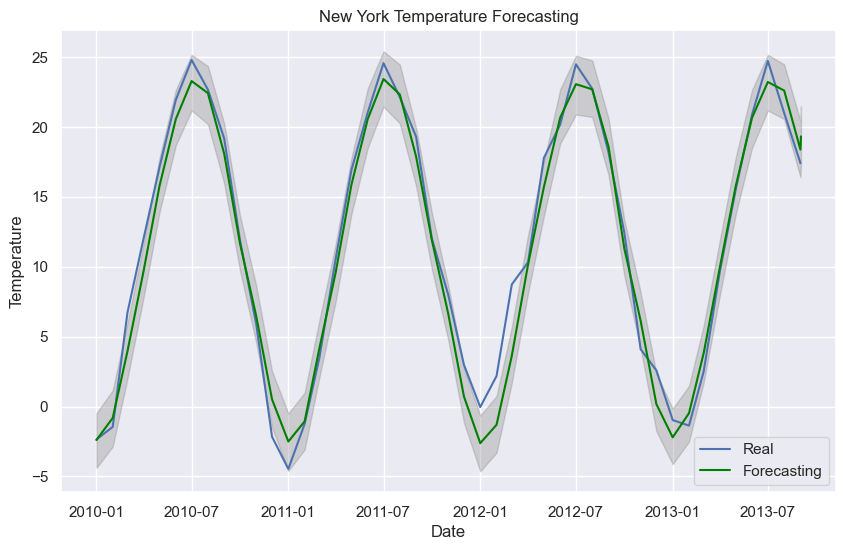

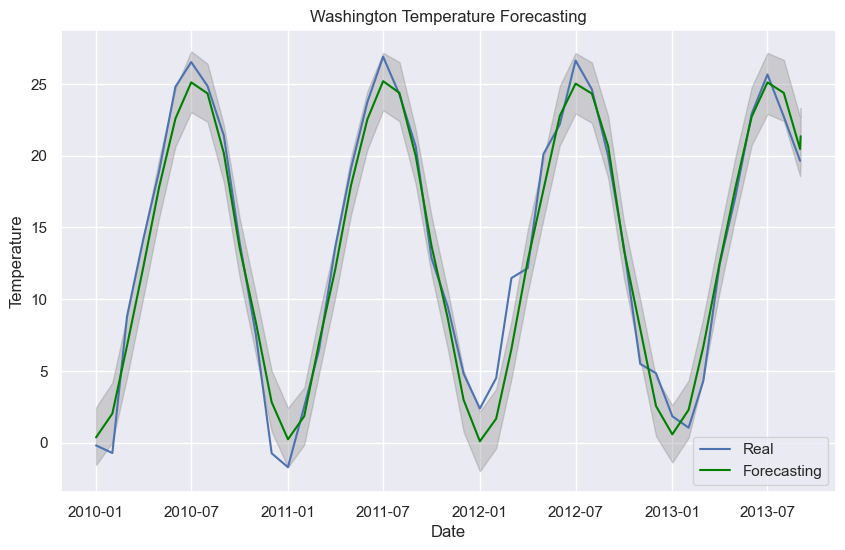

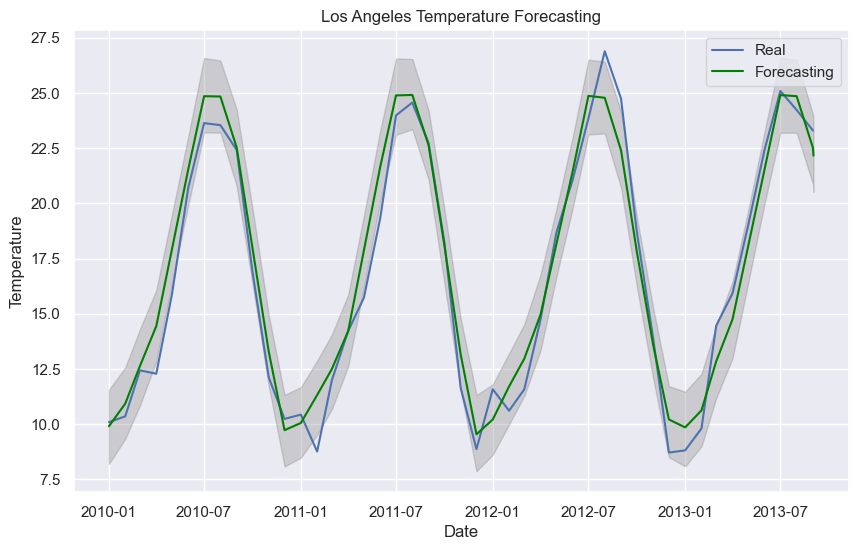

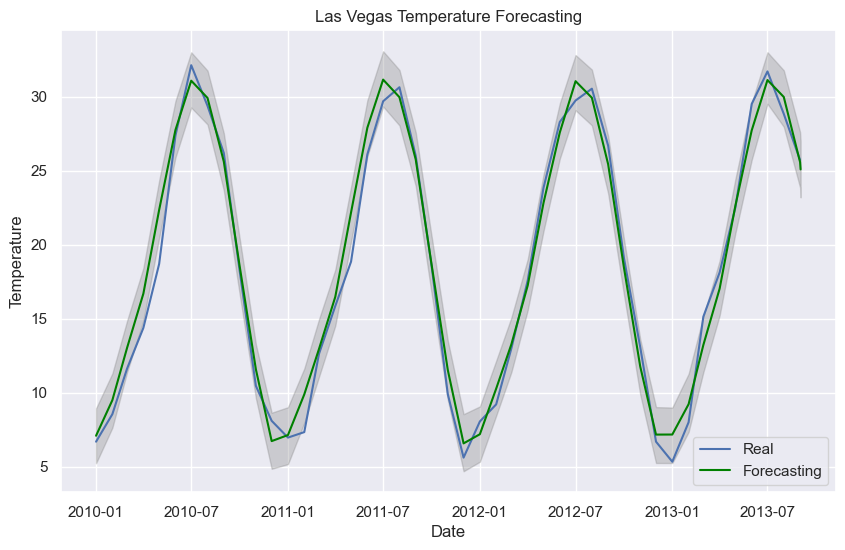

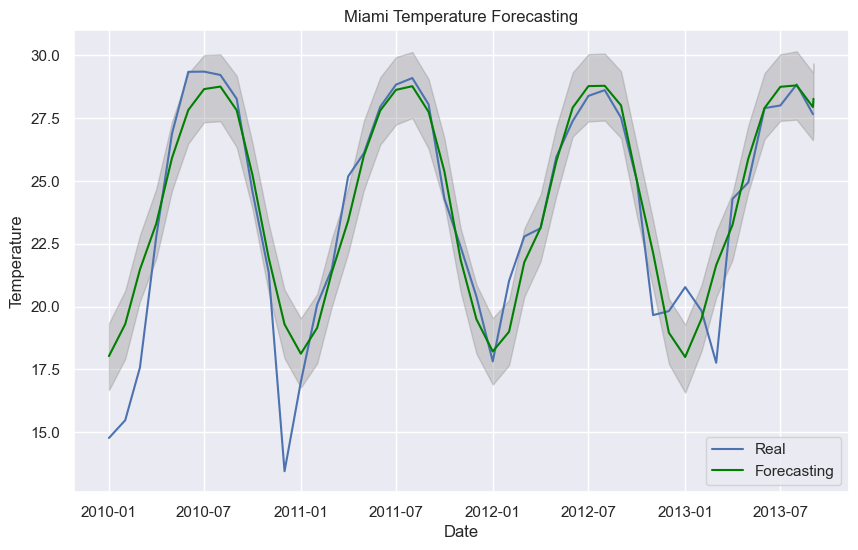

In [74]:
mae = calculate_mean_mae(models, test_city)
print(f'Mean Absolute Error Across All Forecasting Models: {round(mae,3)}') 
mse = calculate_mean_mse(models, test_city)
print(f'Mean Squared Error Across All Forecasting Models: {round(mse,3)}') 
for city in main_cities:
    forecast = forecast_and_plot(city, models, test_city)